In [100]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [101]:
def load_data(folder_path, data_type):        
    with open(folder_path + data_type + ".txt", 'r') as file:
        header_data = file.readlines()
        header_data = [line.strip() for line in header_data]
    if '3' in folder_path:
        return pd.DataFrame({'Header' : header_data})
    with open(folder_path + data_type + "-label.txt", 'r') as file:
        label_data = file.readlines()
        label_data = [line.strip() for line in label_data]    
    return pd.DataFrame({'Header' : header_data, 'Label' : label_data})

In [102]:
train_one = load_data("data/protocol1/", "train")
train_two = load_data("data/protocol2/", "train")
test_one = load_data("data/protocol1/", "test")
test_two = load_data("data/protocol2/", "test")
train_three = load_data("data/protocol3/", "train")

In [103]:
def get_byte_sequence(header_series):
    all_header_string = "".join(header_series.tolist())
    header_double_byte_list = [all_header_string[i:i+2] for i in range(0, len(all_header_string), 2)]
    return header_double_byte_list

def preprocess_data_array(data_array):
    data_hex_string_list = [header for header in data_array.to_list()]
    # print(data_hex_string_list)
    max_packet_length = max(len(header) for header in data_hex_string_list)
    # print(max_packet_length)
    data_bytes_padded_array = np.array([list(packet.ljust(max_packet_length, '0')) for packet in data_hex_string_list])
    # print(data_bytes_padded_array[0])
    data_double_bytes_array = np.array([list(''.join(packet[i:i+2]) for i in range(0, len(packet), 2)) for packet in data_bytes_padded_array])
    # print(data_double_bytes_array[0])
    data_bytes_array = np.vectorize(lambda x: int(x, 16))(data_double_bytes_array)
    # print(data_bytes_array[0])
    data_bytes_normalized_array = data_bytes_array / 255.0
    # print(data_bytes_normalized_array[0])
    # print(data_bytes_normalized_array.shape)
    last_non_zero_col = np.max(np.where(data_bytes_normalized_array != 0)[1])
    return data_bytes_normalized_array[:, :last_non_zero_col + 1]

train_bytes_normalized_array = preprocess_data_array(train_three["Header"])
print(train_bytes_normalized_array.shape)

(9000, 360)


In [104]:
def get_autoencoder(input_dim, latent_dim):
    
    # Encoder
    input_layer = Input(shape=(input_dim, ))
    if input_dim > 256:
        layer_sizes = [256, 64]
    elif input_dim in range(16, 64):
        layer_sizes = [16]
    
    # Small model with only one layer each for encoding and decoding (protocol-2)
    if input_dim < 16:
         encoded = Dense(latent_dim, activation='relu')(input_layer)
         decoded = Dense(input_dim, activation='sigmoid')(encoded)
    else: 
         # Encoder
         encoded = Dense(layer_sizes[0], activation='relu')(input_layer)
         encoded = BatchNormalization()(encoded)
         for size in layer_sizes[1:]:
             encoded = Dense(size, activation='relu')(encoded)
             encoded = BatchNormalization()(encoded)
         encoded = Dense(latent_dim, activation='relu')(encoded)
         # Decoder
         decoded = Dense(layer_sizes[-1], activation = 'relu')(encoded)
         decoded = BatchNormalization()(decoded)
         for size in layer_sizes[-2::-1]:
             decoded = Dense(size, activation='relu')(decoded)
             decoded = BatchNormalization()(decoded)
         decoded = Dense(input_dim, activation='sigmoid')(decoded)
    # Model
    autoencoder = Model(inputs = input_layer, outputs = decoded)
    # Compile
    autoencoder.compile(optimizer = Adam(learning_rate=0.001), loss = 'binary_crossentropy')

    # Define Encoder
    encoder = Model(inputs = input_layer, outputs = encoded)

    # Define Decoder
    encoded_input = Input(shape=(latent_dim,))
    if input_dim < 16:
        decoded_output = autoencoder.layers[-1](encoded_input)
    else:
        layers = 2 * len(layer_sizes) + 1
        decoded_output = autoencoder.layers[-1 * layers](encoded_input)
        layers = layers - 1
        while(layers):
            decoded_output = autoencoder.layers[-1 * layers](decoded_output)
            layers = layers - 1

    decoder = Model(inputs=encoded_input, outputs=decoded_output)
    return autoencoder, encoder, decoder

225/225 [==============================] - 0s 405us/step
(7200, 32)


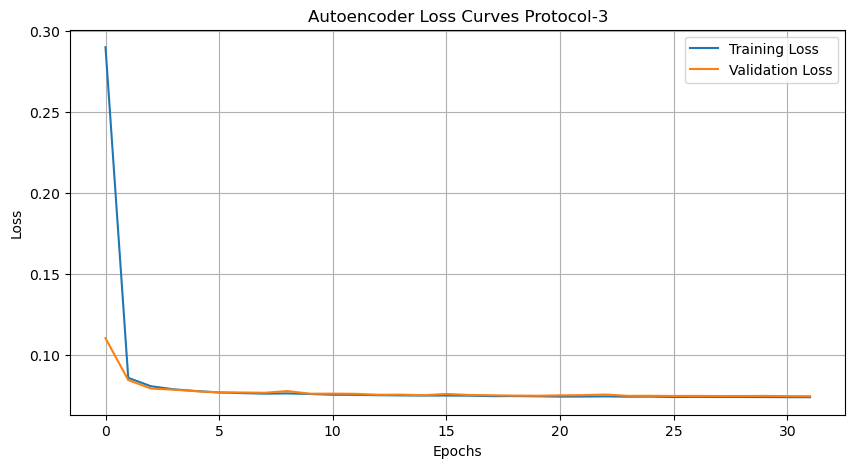

In [105]:
# Autoencoder to reduce dimensionality for non-linear packet header data

# 1. Load preprocessed 2D array of header data
train_bytes_normalized_array = preprocess_data_array(train_three["Header"])
# 2. Define train and test datasets
X_train, X_test = train_test_split(train_bytes_normalized_array, test_size=0.2, random_state=0)
# 3. Get Autoencoder
input_dim = X_train.shape[1]
latent_dim = 32
autoencoder, encoder, decoder = get_autoencoder(input_dim, latent_dim)
# 4. Train the autoencoder
history = autoencoder.fit(X_train, X_train, 
                          epochs = 32, batch_size = 32, 
                          validation_data = (X_test, X_test), verbose = 0)
autoencoder.save_weights('protocol3_weights.h5')
encoder.save_weights('protocol3_encoder_weights.h5')
decoder.save_weights('protocol3_decoder_weights.h5')
loss = autoencoder.evaluate(X_train, X_train)

# 5. Use the encoder to reduce dimensionality
latent_vectors = encoder.predict(X_train)


print(latent_vectors.shape)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Loss Curves Protocol-3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [106]:
print(autoencoder.summary(), end="\n")


Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 360)]             0         
                                                                 
 dense_52 (Dense)            (None, 256)               92416     
                                                                 
 batch_normalization_34 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_53 (Dense)            (None, 64)                16448     
                                                                 
 batch_normalization_35 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_54 (Dense)            (None, 32)                208

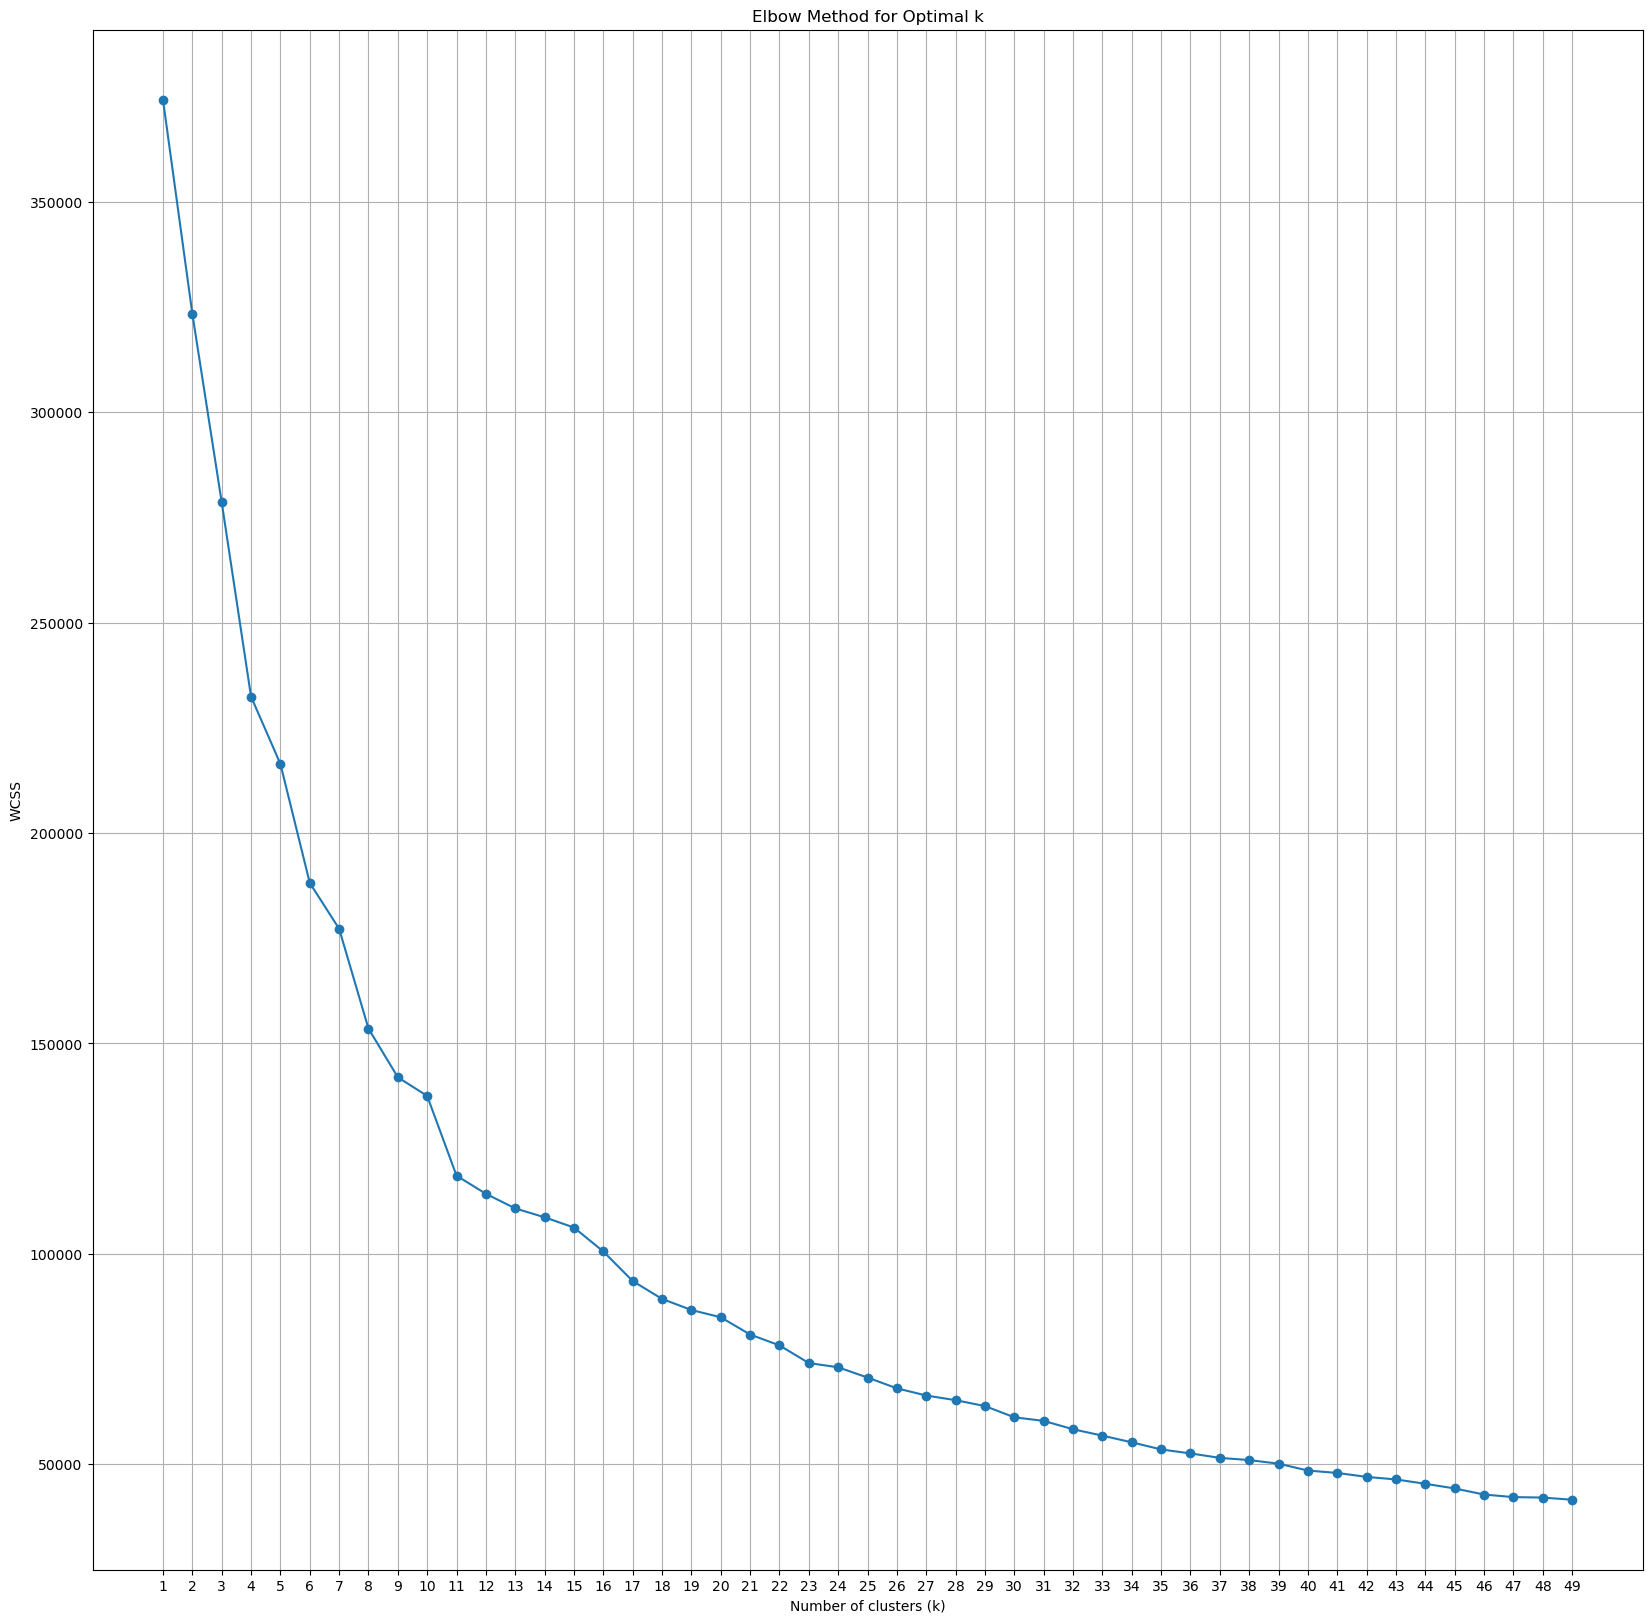

In [107]:
# Elbow method to find optimal k
wcss = []

# Range of k values to try
k_values = range(1, 50)

# Compute KMeans and WCSS for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(latent_vectors)
    wcss.append(kmeans.inertia_)  # inertia is WCSS

# Plotting the Elbow Method
plt.figure(figsize=(20, 20))
plt.plot(k_values, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.xticks(k_values)
plt.grid()
plt.show()

In [114]:
kmeans = KMeans(n_clusters = 16, random_state = 0)
kmeans.fit(latent_vectors)
predicted_clusters = kmeans.labels_
predicted_centroids = kmeans.cluster_centers_
# print(type(predicted_clusters))
predicted_clusters = predicted_clusters[:, np.newaxis]
# print(predicted_clusters)
# print(predicted_clusters.shape, X_train.shape)
data_with_cluster_labels = np.hstack((predicted_clusters, X_train * 255)) 
# print(data_with_cluster_labels[:, 1:])
# print(data_with_cluster_labels.shape)

# Intra-cluster variance per byte
num_fields = X_train.shape[1]
num_clusters = len(np.unique(predicted_clusters))
intra_cluster_var = np.zeros((num_clusters, num_fields))

for cluster in range(num_clusters):
    cluster_data = data_with_cluster_labels[data_with_cluster_labels[:, 0] == cluster][:, 1:]
    intra_cluster_var[cluster] = np.var(cluster_data, axis = 0)
# print(intra_cluster_var.shape)
# print(intra_cluster_var)
intra_cluster_var[intra_cluster_var == 0] = 10 ** 10
# print(np.argmin(intra_cluster_var[:,1:], axis = 1))
result_array = np.sort(np.argsort(intra_cluster_var, axis = 1)[:, :10], axis = 1)
print("\n Protocol-3 Intra Cluster Variance (10 Least) : \n")
print(result_array)
# Getting most occured byte index in first two columns of least variance 
unique_values, counts = np.unique(result_array[:, :1], return_counts=True)
msg_type_byte_index = unique_values[np.argsort(counts)[-1]]
print("\n Predicted Msg-type Index : " , msg_type_byte_index)

# print(np.argsort(intra_cluster_var, axis = 1))
# print(intra_cluster_var)


# predict centroid in actual input space
centroid_data = decoder.predict(predicted_centroids, verbose = 0)

# Inter-cluster variance per byte
inter_cluster_var = np.var(centroid_data, axis = 0)
# print(centroid_data.shape)
# print(inter_cluster_var.shape)
# print(np.argmax(inter_cluster_var))
# print(np.argsort(inter_cluster_var))



 Protocol-3 Intra Cluster Variance (10 Least) : 

[[ 17 246 252 264 274 278 279 283 284 288]
 [  0   8   9  47  51  53 242 244 287 298]
 [ 14  21 246 259 265 276 288 297 302 312]
 [  8 242 253 255 256 259 266 272 283 287]
 [  0 242 244 249 250 255 259 260 262 265]
 [  8   9 242 243 244 353 354 356 357 358]
 [  8  13  14  29  30 247 248 253 298 312]
 [  0  18  22  23 242 244 278 280 286 287]
 [  8  13 253 264 272 273 277 284 286 288]
 [256 257 258 264 270 272 286 294 295 297]
 [  8   9  12 242 259 265 319 320 323 326]
 [  8  29  30 242 243 244 247 248 252 253]
 [ 14  29  30 242 244 247 264 281 288 294]
 [ 14  21 242 246 259 265 282 288 297 303]
 [  7  15  31  32  33 249 250 251 263 278]
 [ 14 248 253 285 291 297 299 300 302 308]]

 Predicted Msg-type Index :  8
